<a href="https://colab.research.google.com/github/cjakuc/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Begin with baselines for classification.
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [x] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [0]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
# from pandas_profiling import ProfileReport
# profile = ProfileReport(train, minimal=True).to_notebook_iframe()

# profile

## Do train/validate/test split with the Tanzania Waterpumps data.

In [0]:
# Split train into train and val
from sklearn.model_selection import train_test_split

train, val = train_test_split(train,
                              train_size=0.80,
                              test_size=0.20,
                              stratify=train['status_group'],
                              random_state=42)

## Begin with baseline for classification

In [6]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

## Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [7]:
top10 = train['funder'].value_counts()[:15]
top10

Government Of Tanzania    7321
Danida                    2491
Hesawa                    1760
Rwssp                     1107
World Bank                1058
Kkkt                      1019
World Vision              1001
Unicef                     840
Tasaf                      719
District Council           684
Dhv                        673
Private Individual         659
Dwsp                       645
Norad                      614
0                          607
Name: funder, dtype: int64

In [8]:
top10 = train['installer'].value_counts()[:10]
top10

DWE                   13978
Government             1458
RWE                     960
Commu                   846
DANIDA                  842
KKKT                    709
Hesawa                  668
0                       607
TCRS                    576
Central government      489
Name: installer, dtype: int64

In [9]:
top10 = train['lga'].value_counts()[:30]
top10

Njombe           2003
Moshi Rural      1005
Arusha Rural      997
Bariadi           931
Kilosa            895
Rungwe            885
Mbozi             827
Kasulu            818
Meru              815
Bagamoyo          797
Singida Rural     789
Kilombero         775
Kibondo           724
Same              693
Kyela             690
Kigoma Rural      679
Kahama            670
Magu              654
Maswa             651
Karagwe           611
Mbinga            604
Iringa Rural      589
Serengeti         569
Namtumbo          553
Ulanga            547
Songea Rural      545
Mvomero           539
Lushoto           535
Mpanda            534
Ngara             513
Name: lga, dtype: int64

In [10]:
top10 = train['construction_year'].value_counts()[:17]
top10

0       16517
2010     2136
2008     2102
2009     2036
2000     1650
2007     1282
2006     1179
2003     1037
2011     1008
2004      909
2012      873
2002      860
1995      822
1978      817
2005      804
1998      793
1990      785
Name: construction_year, dtype: int64

In [11]:
train['construction_year'].value_counts()

0       16517
2010     2136
2008     2102
2009     2036
2000     1650
2007     1282
2006     1179
2003     1037
2011     1008
2004      909
2012      873
2002      860
1995      822
1978      817
2005      804
1998      793
1990      785
1999      776
1985      743
1996      642
1980      638
1984      621
1982      606
1972      581
1994      574
1974      562
1992      519
1997      514
1993      498
2001      427
1988      410
1983      374
1975      349
1986      337
1976      335
1970      329
1991      255
1987      239
1989      238
1981      187
1977      163
1979      152
1973      150
2013      137
1971      111
1960       82
1963       73
1967       71
1968       63
1969       48
1964       35
1962       22
1961       18
1965       16
1966       15
Name: construction_year, dtype: int64

In [0]:
import numpy as np

def wrangle(X):
  """Wrangle, train, validate, and test sets in the same way"""

  X = X.copy()

  # Fix the latitude & longitudes
  X['latitude'] = X['latitude'].replace(-2e-08,0)
  cols_with_zeros = ['longitude','latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0,np.nan)
  
  # Drop duplicate quantity column
  # Drop num_private because of too many zeros
  X = X.drop(columns=['quantity_group','num_private'])
  
  # Change date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])

  # Reduce cardinality:
  # by replacing the non-top founders, installers w/ "other"
  top15 = X['funder'].value_counts()[:15].index
  X.loc[~X['funder'].isin(top15), 'funder'] = 'other'

  top10 = X['installer'].value_counts()[:10].index
  X.loc[~X['installer'].isin(top10), 'installer'] = 'other'

  top30 = X['lga'].value_counts()[:30].index
  X.loc[~X['lga'].isin(top30), 'lga'] = 'other'

  # Return the wrangled dataframe
  return X

# Wrangle train, val, and test
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [13]:
# Select features
target = 'status_group'

# Drop target & id from train columns
train_features = train.drop(columns=[target, 'id'])

# Get a list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series w/ the cardinality of nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of features w/ cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'funder', 'installer', 'basin', 'region', 'lga', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [15]:
# Use a scikit-learn pipeline to encode categoricals, impute missing values,
# and fit a decision tree classifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
)

# Fit on train
pipeline.fit(X_train,
             y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['funder', 'installer', 'basin', 'region',
                                     'lga', 'public_meeting', 'recorded_by',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'sourc...
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf

## Get your validation accuracy score.

In [16]:
# Score on val
print('Validation Accuracy', pipeline.score(X_val,
                                            y_val))
# Score on train
print('Train Accuracy', pipeline.score(X_train, y_train))
# DEFINITELY overfit

Validation Accuracy 0.7598484848484849
Train Accuracy 0.9968855218855219


## Reduce the complexity of the decision tree

In [17]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.808270202020202
Validation Accuracy 0.7760942760942761


## Get and plot your feature importances.

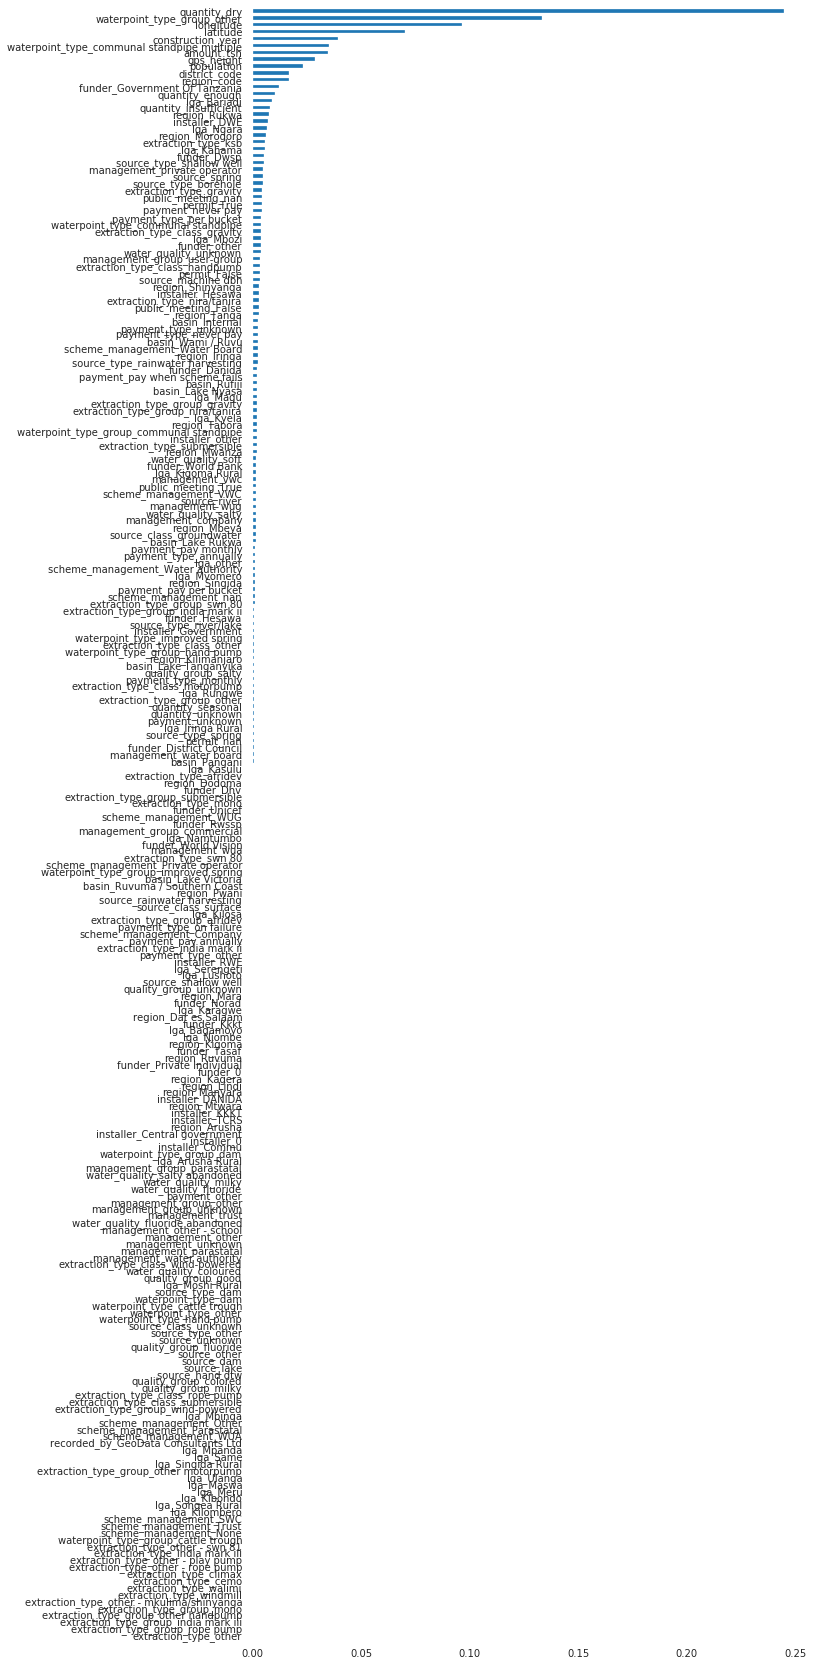

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

## Make a function that selects features, pipes, encodes, imputes, fits a decision tree, and returns pipeline and train/val scores

In [0]:
# Define a function that selects features, pipes, encodes, imputes, and 
# fits a decision tree
# Returns the pipeline and features

def full_pipe(train,val,test):

  # Features:
  # Select features
  target = 'status_group'
  # Drop target & id from train columns
  train_features = train.drop(columns=[target, 'id'])
  # Get a list of numeric features
  numeric_features = train_features.select_dtypes(include='number').columns.tolist()
  # Get a series w/ the cardinality of nonnumeric features
  cardinality = train_features.select_dtypes(exclude='number').nunique()
  # Get a list of features w/ cardinality <= 50
  categorical_features = cardinality[cardinality <= 50].index.tolist()
  # Combine the lists
  features = numeric_features + categorical_features
  
  # Arrange data into X features matrix and y target vector
  X_train = train[features]
  y_train = train[target]
  X_val = val[features]
  y_val = val[target]
  X_test = test[features]

  # Pipeline
  pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
  )
  pipeline.fit(X_train, y_train)
  print('Train Accuracy', pipeline.score(X_train, y_train))
  print('Validation Accuracy', pipeline.score(X_val, y_val))

  return pipeline, features

In [20]:
pipeline, features = full_pipe(train,val,test)

Train Accuracy 0.808270202020202
Validation Accuracy 0.7760942760942761


## Define function to plot feature importance

In [0]:
def plot_features(pipeline,val,features):
  %matplotlib inline
  X_val = val[features]
  model = pipeline.named_steps['decisiontreeclassifier']
  encoder = pipeline.named_steps['onehotencoder']
  encoded_columns = encoder.transform(X_val).columns
  importances = pd.Series(model.feature_importances_, encoded_columns)
  plt.figure(figsize=(10,30))
  importances.sort_values().plot.barh();

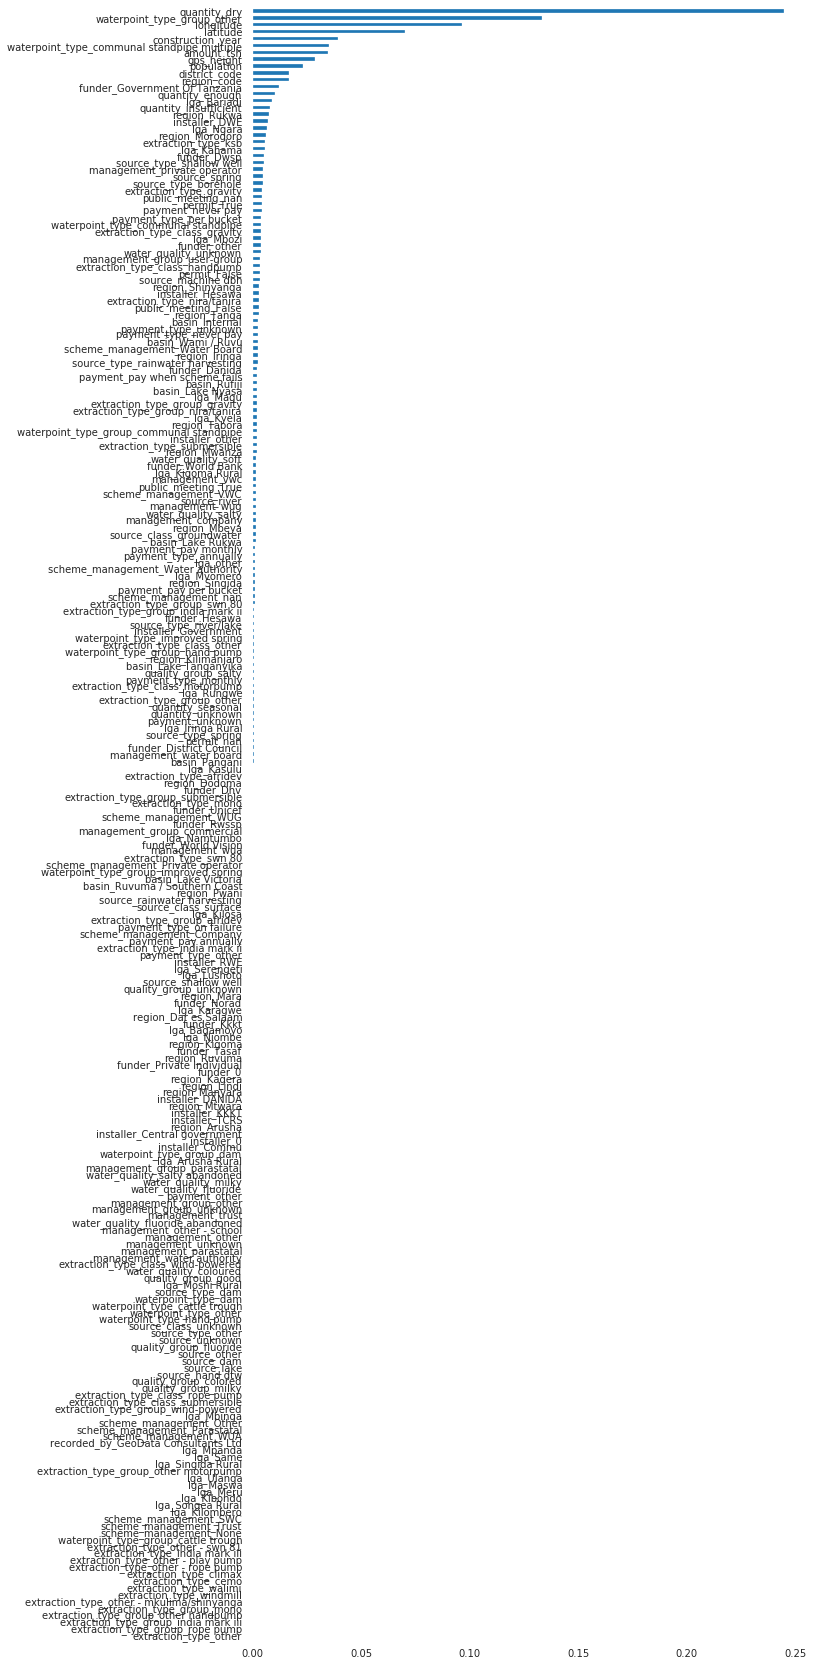

In [22]:
plot_features(pipeline,val,features)

## Continue to improve model through feature selection/engineering by building on the wrangle function

In [0]:
# profile = ProfileReport(train, minimal=True).to_notebook_iframe()

# profile

In [24]:
train['construction_year'].dtypes

dtype('int64')

In [25]:
train['construction_year'].describe()

count    47520.000000
mean      1302.768939
std        950.955437
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [0]:
y_pred = pipeline.predict(X_test)


# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv('https://github.com/cjakuc/DS-Unit-2-Kaggle-Challenge/raw/master/module1-decision-trees/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('cjakuc_tanzania_submission.csv', index=False)